In [2]:
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import pprint


def itemset_type(items):
    """
    Fungsi untuk membuat itemset dari sebuah item / sekumpulan items
    """
    if type(items).__name__ not in ['tuple', 'list']:
        return frozenset([items])
    else:
        return frozenset(sorted(items))

    
def load_data(filepath):
    """
    Fungsi untuk meload data
    """
    transactions = []
    with open(filepath, 'r') as f:
        for line in f:
            transaction = [int(product_id) for product_id in line.strip().split(',')]
            transactions.append(itemset_type(transaction))
    return transactions

# Frequent Itemset Mining

Dalam bagian ini kita akan membahas mengenai teknik menggali frekuensi kemunculan sekumpulan item (itemset) dan mempelajari pola hubungan antar sekumpulan item tersebut (association rule learning).

Di bawah ini terdapat data transaksi yang berupa market basket [1], dengan lebih dari 80 ribu transaksi dengan total 16 ribu lebih item (SKU).
Setiap baris dalam data menjelaskan item apa saja yang dibeli dalam satu transaksi (direpresentasikan dalam bentuk integer `product_id`).

In [3]:
# jalankan fungsi load data
transactions = load_data('files/retail-data.txt')

# tampilkan beberapa data transaksi
for i in range(7):
    print(','.join([str(item) for item in transactions[i]]))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
32,30,31
33,34,35
36,37,38,39,40,41,42,43,44,45,46
48,47,38,39
38,39,48,49,50,51,52,53,54,55,56,57,58
32,41,59,60,61,62


Untuk melihat statistik data, salah satunya kita bisa melihat persebaran jumlah item di tiap transaksi.
Grafik di bawah ini menggambarkan histogram jumlah item per transaksi (itemset size).

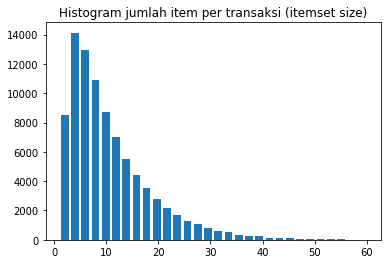

In [4]:
# tampilkan histogram jumlah item per transaksi
transaction_size = [len(transaction) for transaction in transactions]
plt.hist(transaction_size, bins=30, range=(1, 60), rwidth=0.75);
plt.title("Histogram jumlah item per transaksi (itemset size)")
plt.show()

Dari data transaksi di atas, kita akan membuat sebuah mesin recommender dengan mempelajari association rule antar itemset.
Hasil akhirnya adalah sekelompok rule, seperti contoh di bawah ini:

$$
\begin{aligned}
{1} & \to 2\\
{20, 40} &\to 59
\end{aligned}
$$

Artinya, jika customer A membeli item `1` maka kita dapat merekomendasikan untuk membeli item `2`.
Jika membeli item `20` dan `40` maka kita dapat merekomendasikan item `59`.
Setiap rule menunjukkan bahwa item - item dalam rule tersebut sering muncul dalam data transaksi terdahulu.

## Apriori

Algoritma alpriori dapat dipakai untuk mencari frekuensi dari tiap - tiap item atau kumpulan item (itemset) yang sering muncul (memenuhi kriteria jumlah minimum / support) di database. 
Informasi ini dapat digunakan untuk mengetahui hubungan asosiasi antar item / itemset yang kemudian dapat dimanfaatkan untuk melakukan analisis keranjang belanja (market basket analysis) ataupun sebagai recommender.

Detail algoritma Apriori dijelaskan sebagai berikut [2]:

$$
\begin{aligned}
    & T: \text{list of transactions}\\
    & I: \text{frequent itemsets}\\
    & \epsilon: \text{minimum support}\\
    & \theta: \text{minimum confidence}
\end{aligned}
$$

$$
\begin{aligned}
    I = & ~\mathrm {Apriori} (T, \epsilon)\\
    & \qquad L_1 = \text{find frequent items with set size 1}\\
    & \qquad k = 2 \\
    & \qquad \textbf{while} ~L_{k-1} \neq \emptyset\\
    & \qquad \qquad C_k = \text{find candidate itemsets with size k} (L_{k-1})\\
    & \qquad \qquad \textbf{for} ~\text{transaction} ~t \in T\\
    & \qquad \qquad \qquad \textbf{for} ~\text{candidate} ~c \in C_k\\
    & \qquad \qquad \qquad \qquad \textbf{if} ~c ~\text{is subset of} ~t\\
    & \qquad \qquad \qquad \qquad \qquad count[c] = count[c] + 1\\
    & \qquad \qquad L_{k} = c \mid c \in C_{k} \land ~count[c] \geq \epsilon \\
    & \qquad \qquad k = k + 1\\
    & \qquad \textbf{return} ~\bigcup _{k}L_{k}
\end{aligned}
$$

$$
\begin{aligned}
    I = & ~\mathrm {GenerateRule}(I, \theta)\\
    & \qquad Rule = \emptyset\\
    & \qquad \textbf{for} ~\text{itemset} ~i \in I_{2..n}\\
    & \qquad \qquad S = ~\text{generate non-empty subset of} ~i\\
    & \qquad \qquad \textbf{for} ~\text{subset} ~s \in S\\
    & \qquad \qquad \qquad \qquad \textbf{if} ~count[i] \div count[s] \geq \theta\\
    & \qquad \qquad \qquad \qquad \qquad Rule \cup s \to (i - s)\\
    & \qquad \textbf{return} ~Rule
\end{aligned}
$$

In [5]:
def create_initial_frequent_itemsets(transactions, min_support):
    """
    Fungsi untuk mendapatkan sejumlah itemset awal dengan jumlah 1 item
    dibatasi hanya itemset yang memenuhi minimum support
    """
    
    itemsets = set()
    counter = Counter()
    
    # untuk setiap item di transaksi
    # hitung frekuensi kemunculan item tersebut
    # dan tambahkan itemset ke dalam variabel itemsets
    for transaction in transactions:
        for item in transaction:
            itemset = itemset_type(item)
            counter[itemset] += 1
            itemsets.add(itemset)
            
        
                
    # filter itemset yang memenuhi minimum support
    new_itemsets = set()
    for itemset in itemsets:
        if counter[itemset] >= min_support:
            new_itemsets.add(itemset)
            
    return new_itemsets, counter


def generate_candidate_sets(previous_set, size):
    """
    Fungsi untuk menghasilkan candidate itemset ukuran k
    dari kumpulan itemset dengan ukuran k-1
    """
    
    itemset = set()
    
    # untuk setiap item in previous_set
    # union dengan item lain di previous set
    for item1 in previous_set:
        for item2 in previous_set:
            if len(item1.union(item2)) == size:
                itemset.add(item1.union(item2))
                
    return itemset


def get_frequent_itemsets(candidate_sets, transactions, min_support):
    """
    Fungsi untuk menghasilkan frequent itemset
    yang memenuhi minimum support
    dari candidate sets yang diberikan
    """
    
    itemsets = set()
    counter = Counter()
    
    # untuk setiap transaksi t
    # untuk setiap candidate itemset i
    # cek apakah itemset tersebut subset dari transaksi t
    # increment counter itemset i
    for t in transactions:
        for c in candidate_sets:
            if c.issubset(t):
                counter[c] += 1
                    
    # filter itemset yang memenuhi minimum support
    for c in candidate_sets:
        if counter[c] >= min_support:
            itemsets.add(c)
            
    return itemsets, counter


def generate_subsets(itemset):
    """
    Fungsi untuk menghasilkan non-empty subsets dari itemset yg diberika
    """
    
    subsets = []
    
    # generate subset dengan size [1, size(itemset) - 1]
    for i in range(1, len(itemset)):
        cs = combinations(itemset, i)
        for c in cs:
            subsets.append(itemset_type(c))
            
    return subsets


def generate_association_rules(frequent_itemsets_list, counter, min_confidence):
    """
    Fungsi untuk menghasilkan association rule
    dengan minimum confidence tertentu
    dari frequent itemsets yang telah dihasilkan
    """
                
    rules = {}
    
    # generate rules
    for itemsets in frequent_itemsets_list:
        for i in itemsets:
            subsets = generate_subsets(i)
            for s in subsets:
                if counter[i] / float(counter[s]) >= min_confidence:
                    rules[s] = i - s
    
                    
    return rules
    
    
def apriori(transactions, min_support):
    """
    Fungsi utama algoritma apriori
    """
    
    frequent_itemsets_list = []
    counter_all = Counter()
    
    # cari frequent itemset awal dengan jumlah item == 1
    itemsets, counter = create_initial_frequent_itemsets(transactions, min_support)
    # print(itemsets)
    # print(counter)
    
    counter_all.update(counter)
    frequent_itemsets_list.append(itemsets)
    
    # while-loop
    k = 1
    while len(frequent_itemsets_list[k-1]) != 0:
        # 1. cari daftar kandidat itemsets ukuran k dari
        # frequent_itemsets_list[k - 1]
        csets = generate_candidate_sets(frequent_itemsets_list[k-1], k + 1)
        # print(csets)
        
        # 2.
        itemsets, counter = get_frequent_itemsets(csets, transactions, min_support)
        # print(itemsets)
        
        frequent_itemsets_list.append(itemsets)
        counter_all.update(counter)
        
        k += 1
    
    return frequent_itemsets_list, counter_all
    
    
frequent_itemsets_list, counter_all = apriori(transactions, 1000)
# pprint.pprint(frequent_itemsets_list)
# pprint.pprint(counter_all)
rules = generate_association_rules(frequent_itemsets_list, counter_all, 0.6)
pprint.pprint(rules)

{frozenset([48, 310]): frozenset([39]),
 frozenset([101]): frozenset([39]),
 frozenset([48, 41]): frozenset([39]),
 frozenset([38]): frozenset([39]),
 frozenset([79]): frozenset([39]),
 frozenset([48, 36, 38]): frozenset([39]),
 frozenset([32, 41]): frozenset([48]),
 frozenset([48, 65]): frozenset([39]),
 frozenset([48, 110, 39]): frozenset([38]),
 frozenset([147]): frozenset([39]),
 frozenset([48, 110, 38]): frozenset([39]),
 frozenset([310, 39]): frozenset([48]),
 frozenset([48, 170]): frozenset([38, 39]),
 frozenset([32, 41, 48]): frozenset([39]),
 frozenset([48, 36, 39]): frozenset([38]),
 frozenset([32, 38]): frozenset([39]),
 frozenset([170, 38]): frozenset([39]),
 frozenset([170, 39]): frozenset([38]),
 frozenset([237, 39]): frozenset([48]),
 frozenset([32, 39]): frozenset([48]),
 frozenset([48, 41, 38]): frozenset([39]),
 frozenset([237]): frozenset([39]),
 frozenset([48, 170, 38]): frozenset([39]),
 frozenset([110]): frozenset([38, 39]),
 frozenset([48, 237]): frozenset([39]),

## References:

[1] Brijs T., Swinnen G., Vanhoof K., and Wets G. (1999), The use of association rules for prod-
uct assortment decisions: a case study, in: Proceedings of the Fifth International Conference on
Knowledge Discovery and Data Mining, San Diego (USA), August 15-18, pp.  254-260.  ISBN:
1-58113-143-7.

[2] Apriori algorithm. (2017, October 6). In Wikipedia, The Free Encyclopedia. Retrieved 04:18, October 20, 2017, from https://en.wikipedia.org/w/index.php?title=Apriori_algorithm&oldid=804041500